## Import, Upload & Inspect

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

filename = "Data/insurance - insurance.csv"
df = pd.read_csv(filename)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Original Population Inspection

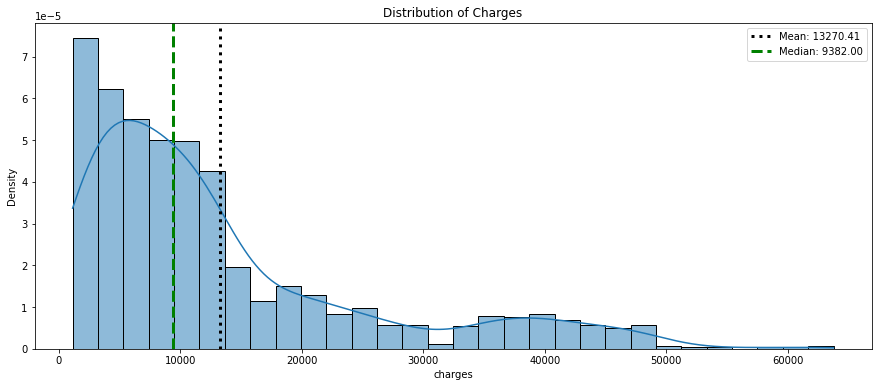

In [3]:
data = df["charges"].copy().round()
mean = np.mean(data)
med = np.median(data)

fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(x=data,kde=True,ax=ax,stat='density')
ax.set_title("Distribution of Charges")

ax.axvline(mean,ls=':', color='black', lw=3, label =f"Mean: {mean:.2f}")
ax.axvline(med,ls='--', color='green', lw=3, label =f"Median: {med:.2f}")
ax.legend();


## Q1. Do smokers have higher insurance charges than non-smokers?
- **Null Hypothesis:** There is no significant difference in insurance charges between smokers and non-smokers. 
- **Alternate Hypothesis:** There is a statistical difference between insurance charges of smokers and non-smokers. 
- **Test:** 2 Sample T-Test (Numerical, 2 Samples)
- **Groups:** Smoker/NonSmoker
- **Target:** Charges


In [4]:
df["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
needed_cols = ["smoker", "charges"]
df[needed_cols]

,smoker,charges
0,yes,16884.92400
1,no,1725.55230
2,no,4449.46200
3,no,21984.47061
4,no,3866.85520
...,...,...
1333,no,10600.54830
1334,no,2205.98080
1335,no,1629.83350
1336,no,2007.94500


In [6]:
df["smoker"].unique()

array(['yes', 'no'], dtype=object)

In [7]:
groups = {}

for smoker in df["smoker"].unique():
    temp = df.loc[df["smoker"] == smoker, "charges"]
    groups[smoker] = temp
groups.keys()

dict_keys(['yes', 'no'])

In [8]:
groups["yes"]

0       16884.92400
11      27808.72510
14      39611.75770
19      36837.46700
23      37701.87680
           ...     
1313    36397.57600
1314    18765.87545
1321    28101.33305
1323    43896.37630
1337    29141.36030
Name: charges, Length: 274, dtype: float64

In [9]:
#Find and Drop Outliers
temp = np.abs(stats.zscore(groups["yes"])) > 3
temp.value_counts()

False    274
Name: charges, dtype: int64

In [10]:
for smoker, data in groups.items():
    outliers = np.abs(stats.zscore(data)) > 3
    print(f"There were {outliers.sum()} outliers in the {smoker} group")
    data = data.loc[~outliers]
    groups[smoker] = data

There were 0 outliers in the yes group
There were 24 outliers in the no group


In [11]:
#Assumption of Normality Test
#This function tests the null hypothesis that a sample comes from a normal distribution.
norm_results = [["group", "n", "pval", "reject null?"]]

for smoker, data in groups.items():
    stat, p = stats.normaltest(data)
    norm_results.append([smoker, len(data), p, p <.05])
    
normal_results = pd.DataFrame(norm_results[1:], columns = norm_results[0])
normal_results

,group,n,pval,reject null?
0,yes,274,5.564931e-14,True
1,no,1040,2.694542e-36,True


Our data does not come from a normal distribution. However our sample is large enough to safely ignore the normality assumption. 

In [12]:
#Assumption of Equal Variance 
# This function tests the null hypothesis that variance is equal across all samples. 
result = stats.levene(*groups.values())
print(result)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


In [13]:
if result.pvalue < .05:
    print(f"The groups do not have equal variances")
else:
    print(f"The groups DO have equal variance")

The groups do not have equal variances


In [14]:
#Final T-Test
result = stats.ttest_ind(*groups.values(), equal_var = False)
print(result)
result.pvalue < .05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

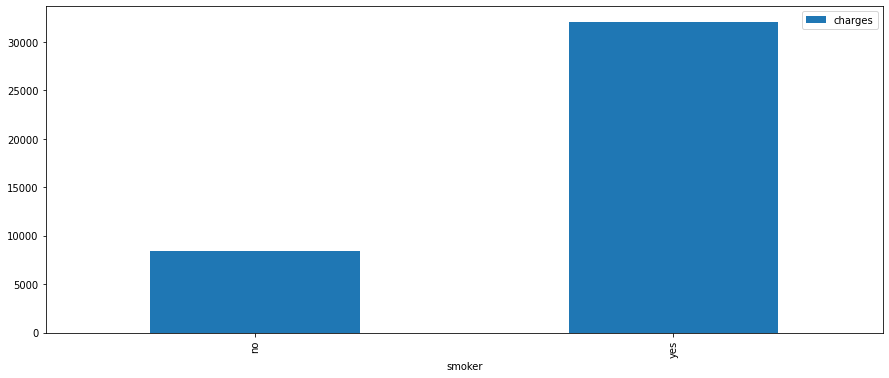

In [15]:
fig, ax = plt.subplots(figsize=(15,6))

avg_charges = df.groupby(["smoker"])["charges"].mean()
avg_charges.plot(kind = "bar", x = "smoker", y = "charges")
ax.legend();

## Answer: 
- We reject the Null Hypotheses, indicating there is a statistical difference in insurance charges between smokers and non-smokers

## Q2. Are men more likely to smoke than women?
- **Null Hypothesis:** There is no significant relationship between sex and smoker status.
- **Alternate Hypothesis:** A person's sex influences their smoking status.
- **Test:** Chi Square (2 Samples, Categorical Data)
- **Groups:** Sex
- **Target:** Smoker/Non-smoker


In [16]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df["sex"], df["smoker"])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [17]:
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result
print(p)
p < .05

0.006548143503580696


True

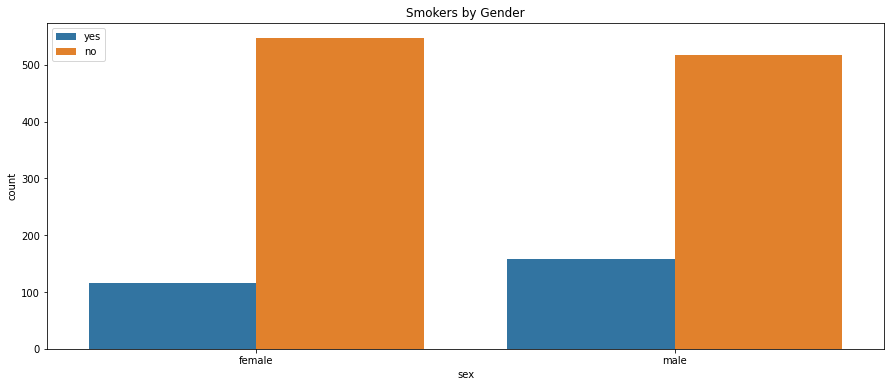

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.countplot(data = df, x = "sex", hue = "smoker")
ax.set_title("Smokers by Gender")
ax.legend();

## Answer: 
- We reject the Null Hypothesis indicating a person's gender does influence their smoking status. 

## Q3. Do different regions have different charges, on average?
- **Null Hypothesis:** There is no significant difference in insurance charges across regions. 
- **Alternate Hypothesis:** There is a significant difference in insurance charges across regions. 
- **Test:** ANOVA (More than two groups, Numerical Data)
- **Groups:** Regions
- **Target:** Charges

In [19]:
df["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [20]:
needed_cols_2 = ["region", "charges"]
df[needed_cols_2]

,region,charges
0,southwest,16884.92400
1,southeast,1725.55230
2,southeast,4449.46200
3,northwest,21984.47061
4,northwest,3866.85520
...,...,...
1333,northwest,10600.54830
1334,northeast,2205.98080
1335,southeast,1629.83350
1336,southwest,2007.94500


In [21]:
df["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [22]:
groups_2 = {}

for region in df["region"].unique():
    temp_2 = df.loc[df["region"] == region, "charges"]
    groups_2[region] = temp_2
groups_2.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [23]:
groups_2["southwest"]

0       16884.92400
12       1826.84300
15       1837.23700
18      10602.38500
19      36837.46700
           ...     
1316     1731.67700
1329    10325.20600
1331    10795.93733
1332    11411.68500
1336     2007.94500
Name: charges, Length: 325, dtype: float64

In [24]:
#Find and Drop Outliers
temp_2 = np.abs(stats.zscore(groups_2["southwest"])) > 3
temp_2.value_counts()

False    317
True       8
Name: charges, dtype: int64

In [41]:
for region, data_2 in groups_2.items():
    outliers_2 = np.abs(stats.zscore(data_2)) > 3
    print(f"There were {outliers_2.sum()} outliers in the {region} group")
    data_2 = data_2.loc[~outliers_2]
    groups_2[region] = data_2

There were 0 outliers in the southwest group
There were 0 outliers in the southeast group
There were 0 outliers in the northwest group
There were 0 outliers in the northeast group


In [26]:
#Assumption of Normality Test
#This function tests the null hypothesis that a sample comes from a normal distribution.
norm_results_2 = [["group", "n", "pval", "reject null?"]]

for region, data_2 in groups_2.items():
    stat, p = stats.normaltest(data_2)
    norm_results_2.append([region, len(data_2), p, p <.05])
    
normal_results_2 = pd.DataFrame(norm_results_2[1:], columns = norm_results_2[0])
normal_results_2

,group,n,pval,reject null?
0,southwest,317,7.728611e-22,True
1,southeast,362,1.936990e-13,True
2,northwest,318,2.940543e-19,True
3,northeast,320,3.557877e-17,True


### Our data does not come from a normal distribution. However our sample is large enough to safely ignore the normality assumption. 

In [44]:
#Assumption of Equal Variance 
# This function tests the null hypothesis that variance is equal across all samples. 
normal_result_2 = stats.levene(*groups_2.values())
print(result_2)

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)


In [45]:
if result_2.pvalue < .05:
    print(f"The groups do not have equal variances")
else:
    print(f"The groups DO have equal variance")

The groups do not have equal variances


### We reject the null hypothesis that these groups have equal variances. Therefore we will have to use a non-parametric test.

In [49]:
#Final ANOVA Test
result_2 = stats.kruskal(*groups.values())
print(result)
result_2.pvalue < .05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

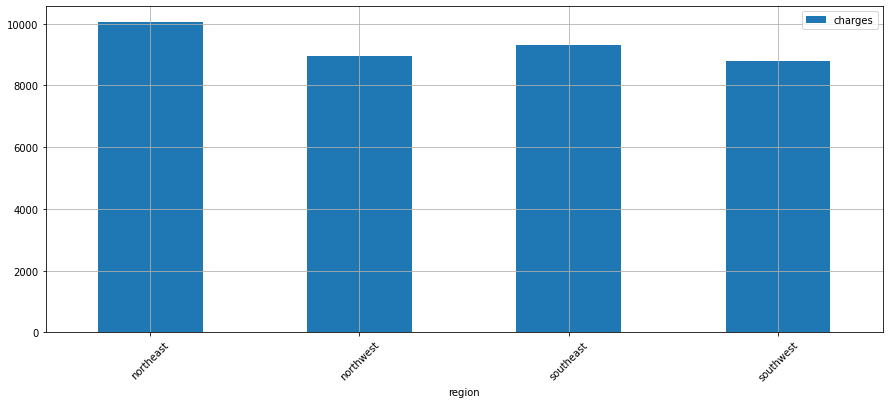

In [52]:
fig, ax = plt.subplots(figsize=(15,6))

region_charges = df.groupby(["region"])["charges"].median()
region_charges.plot(kind = "bar", x = "region", y = "charges")
ax.grid(True)
plt.xticks(rotation = 45)
ax.legend();

### Our p value is less than our alpha, therefore we reject the null hypothesis meaning there is a significant difference in charges by region. 